# Simple Recommender

- 아이디어: <u>'대부분의 사람들이 좋아하면 나도 좋아할 것이다'</u>
- 인기도에 기반하여 모든 사용자에게 똑같은 추천을 하는 방법
- 예를 들어 음악이나 영화를 볼 때 사람들은 인기 차트를 참고

목차<br>
1. 가중치를 통한 평점과 투표 수 반영<br>
    1) 가중 평균을 통한 보정 방법<br>
    2) 신뢰구간을 이용하여 평점과 투표수 반영<br>
2. 최신 글일 수록 상위권에 노출하는 방법<br>
    1) Hacker News 추천 방식<br>
    2) Reddit의 추천 방식<br>
3. 연결성에 초점을 둔 추천 방식
4. Simple Recommender의 한계

# 1. 가중치를 통한 평점과 투표 수 반영

- 평점이 높은 상품이 좋은 상품일 것이다
- 하지만 평점은 단순 평균이기 때문에 많은 사람들이 좋아하는지 반영할 수가 없음<br>
예를들어 1명이 10점을 준 영화보다 1000명이 9점을 준 영화가 더 좋은 영화일 가능성이 높음<br>
- 또한 영화의 전체적인 평점 역시 고려해야함<br>
전체적인 상품의 평점이 10점만점에 9점이면 높은 점수가 아님
- 영화나 음악 검색 사이트에서 많이 사용하는 방식

# <b>1) 가중 평균을 통한 보정 방법</b>

$Weighted Average(WR)= (\frac{v}{v+m}\cdot R)+(\frac{m}{v+m}\cdot C)$<br>
$v$: 투표한 사람의 수<br>
$m$: 차트에 등재 되기 위한 최소 투표 수<br>
$R$: 각 상품에 대한 평점<br>
$C$: 전체 평균 투표 수<br>
- 평균 투표 수와 평균 평점의 가중 평균으로 점수 부여
- 최소 투표 수 $m$을 지정 <br>
=> $m$이 작을 수록 $C$가 낮아져 투표 한 사람이 많을 수록 상품의 평점이 많이 반영<br>
=> $m$이 클 수록 $C$가 높아짐 

<b>데이터 소개</b>
- Full MovieLens 데이터셋에서 45,000개의 영화에 대한 데이터
- 영화에 대한 사람들의 평가(평점, 투표수)와 영화에 대한 정보(장르, 개봉일 등)가 있는 데이터


In [4]:
import os
import pandas as pd
os.chdir('C:/Users/bki19/Desktop/recommender_system')
metadata =  pd.read_csv('./data/the-movies-dataset/movies_metadata.csv', low_memory=False)
metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [3]:
# Calculate C
C = metadata['vote_average'].mean()
print(C)

5.618207215134185


10점 만점에서 평균 점수는 5.61점

160.0


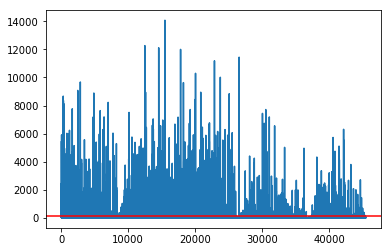

In [24]:
# Calculate the minimum number of votes required to be in the chart, m
m = metadata['vote_count'].quantile(0.90)
print(m)

import matplotlib.pyplot as plt
plt.plot(metadata['vote_count'])
plt.axhline(y=m,color='red')

상위 10퍼센트의 투표 수를 가진 영화는 160표 이상<br>
$m=160$으로 설정하여 상위 10퍼센트의 영화

In [25]:
# Filter out all qualified movies into a new DataFrame
q_movies = metadata.copy().loc[metadata['vote_count'] >= m]
q_movies.shape

(4555, 24)

최소 투표 수를 받지 못한 영화는 모두 제거 (90퍼센트가 제거 됨)

In [27]:
# Function that computes the weighted rating of each movie
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [28]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 10 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.445869
834,The Godfather,6024.0,8.5,8.425439
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421453
12481,The Dark Knight,12269.0,8.3,8.265477
2843,Fight Club,9678.0,8.3,8.256385
292,Pulp Fiction,8670.0,8.3,8.251406
522,Schindler's List,4436.0,8.3,8.206639
23673,Whiplash,4376.0,8.3,8.205404
5481,Spirited Away,3968.0,8.3,8.196055
2211,Life Is Beautiful,3643.0,8.3,8.187171


- 인기 차트에 사람들이 많이 투표한 평점 높은 영화가 추천 됨
- 쇼생크 탈출, 대부, Dilwale Dulhania Le Jayenge 등의 영화가 최상의 점수를 받음
- 평점 상으로 Dilwale Dulhania Le Jayenge가 쇼생크 탈출 보다 높지만 투표수가 10분의 1도 안되기 때문에 점수는 더 낮게 책정 됨<br>
=> 단순한 방식이지만 영화 인지도를 봤을 때 어느 정도 그럴듯한 추천 결과가 나옴

# <b>2) 신뢰구간을 이용하여 평점과 투표수 반영</b>

- 미국 커뮤니티 사이트 Reddit에서 인기 댓글을 보여줄 때 Wilson의 Score interval 사용하는 것으로 알려짐
- 댓글 같은 경우 최신 글 보다는 '좋아요'가 많은 댓글이 이슈를 잘 반영할 수 있음<br>
=> 보통 처음 달린 댓글들에 사람들이 좋아요를 많이 누르고 처음 댓글에 나중에 달리는 댓글이 영향을 많이 받기 때문에 최근 댓글이 중요하지 않을 수 있음<br>
- 신뢰 구간은 샘플의 크기가 많아질 수록 줄어든 다는 성질을 이용하여 투표 수가 많은 댓글에 점수를 더 주는 방법

<b>Wald test</b><br>
<br>
$X \sim Bernoulli(p)$: 각각의 글은 $p$의 확률로 좋아요나 싫어요를 받게 됨<br>
$H_{0}: p=p_{0}$: 좋아요를 받을 확률<br>
<br>
Confidence interval: $p_{0}\in (\hat{p}\pm z_{\alpha/2} \sqrt{ \frac{  \hat{p}(1-\hat{p}) }{2} } )$<br>
- Binomial 분포를 Normal 분포에 근사한 것이기 때문에 sample의 숫자가 많아야 됨
- 심플하기 때문에 일반적으로 가장 많이 씀
- 하지만 $\hat{p}$이 1이나 0이 되면 variance 부분이 0이 되서 좋아요만 받은 글이나 싫어요만 받은 글끼리 같은 신뢰구간을 갖게 됨<br>
=> 투표수를 제대로 고려 못하게 됨

<b>Wilson의 Score Interval</b><br>
<br>
Wilson의 방법은 $Var(p)$를 $\frac{  \hat{p}(1-\hat{p}) }{2} $으로 MLE $\hat{p}$의 함수로 추정하지 않고 <br>
$p= (\hat{p}\pm z_{\alpha/2} \sqrt{ \frac{  p(1-p) }{n} } )$로 두어 신뢰 구간을 직접 구함<br>
이를 전개하면 신뢰구간은<br>
Confidence interval: ($p_{0} \in \frac{\hat{p}+\frac{z^{2}}{2N} }{ 1+\frac{z^{2}}{N} }\pm \frac{z}{ 1+\frac{z^{2}}{N} } \sqrt{\frac{\hat{p}(1-\hat{p})  }{N }+\frac{z^{2}}{4N^{2}}  })$<br>
- 이 때의 신뢰 구간의 길이는 two sample proportional test보다 짧음

<b>Wilson의 방법의 장점</b>
- Wilson의 방법은 신뢰 구간의 하한을 통해 정렬하는 방식
- 신뢰 구간은 샘플이 작아질 수록 줄어들기 때문에 투표를 조금 받은 글은 하한의 값이 작아지게 됨
- 좋아요의 비중이 높은 글은 평균이 높아지기 때문에 신뢰 구간의 중심이 오른쪽으로 이동
=> 투표의 수와 좋아요의 비중을 동시에 고려할 수 있게 됨
- two sample proportional test보다 신뢰 구간이 짧아 귀무 가설의 기각을 더 잘하게 됨
- 두 방법 모두 샘플이 커질 수록 Normal 분포에 수렴한다는 근사적 성질을 이용해야하지만 Wilson의 방법이 더 로버스트함 

<b>Wilson과 Wald의 방법 비교</b>

In [2]:
from scipy.stats import norm

def Wald_test(XA,XB,alpha=0.05):
    N=(XA+XB)
    if N==0:
        return 0
    else:
        p=XA/N
        alpha=0.05
        z=norm.ppf(1-alpha)
        lower=p- z*(( p*(1-p)/N   )**0.5)
        return lower

In [3]:
from math import sqrt

def Wilson_test(ups, downs,alpha=0.05):
    n = ups + downs
    if n==0:
        return 0
    else:

        z=norm.ppf(1-alpha)
        p = ups / n

        left = p + 1/(2*n)*z*z
        right = z*( (p*(1-p)/n + z*z/(4*n*n)) **0.5)
        under = 1+1/n*z*z

        return (left - right) / under


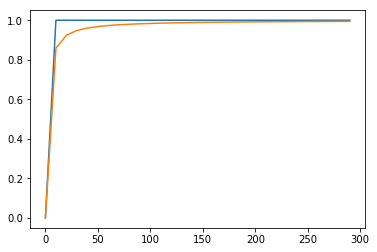

In [4]:
import numpy as np
import matplotlib.pyplot as plt
A=np.arange(0,300,10)
B=np.repeat(0,len(A) )
Wald=[Wald_test(x,0,0.1) for x in A ]
Wilson=[Wilson_test(x,0,0.1) for x in A ]
plt.plot(A,Wald )
plt.plot(A,Wilson )

- 좋아요만 10개, 20개,... 1000개 받았을 때 Wald와 Wilson의 방법 비교
- 파란색은 Wald의 방법으로 샘플 수에 관계없이 획일된 점수를 부여함
- 주황색은 Wilson의 방법으로 샘플 수가 커질 수록 조금씩 더 큰 점수를 줌

In [6]:
import os
import pandas as pd
os.chdir('C:/Users/bki19/Desktop/recommender_system')
df=pd.read_csv('./data/comment3.csv', encoding='cp949')
XA=df['like']
XB=df['hate']

In [5]:
df.head()

,id,hour,comment,like,hate,num
0,0,60,솔직히 다 알지ㅋㅋㅋ 그래도 레알 이적설 뜨는거는 기분 좋다,526,36,28
1,1,60,찌라시인거 모르는사람있음?ㅋㅋㅋㅋ 레알이적설 나올만큼 성장했다는게 중요한거지 ㅋㅋ,238,54,21
2,2,60,하 저도 레알마드리드 꼭가고 싶습니다.ㅠㅠ,89,36,12
3,3,60,베일정도는 정리해야 자리가있지.,66,8,12
4,4,60,논Eu 랑 이적자금등 이미 현재로 어려운건 알던건데 관심받는게 대단한거지,45,15,8


데이터 소개<br>
- 인터넷 축구 기사 댓글<br>
- 해당 사이트에서는 좋아요가 많은 순으로 정렬 후 같은 수의 좋아요를 받은 경우 싫어요가 적은 순으로 위에 노출하는 방식(좋아요가 4개 이하이면 시간순으로 배열) 
- 위 사이트에 Wald와 Wilson의 방법을 적용 하면 댓글 순위가 많이 바뀔까?

In [6]:
df['Wald_score']=[Wald_test(XA[x],XB[x],0.1)  for x in range(len(XA)  )  ]

In [7]:
df = df.sort_values('Wald_score', ascending=False)
df.head()

,id,hour,comment,like,hate,num,Wald_score
36,36,14,선수가 직접 아니라고 이미 확실히 말했구만 끈질기다. 레알 마드리드 내부 사정을 잘...,2,0,0,1.0
20,20,19,믿고 거르는 한준 기사,4,0,0,1.0
58,58,60,이게 팩트지,1,0,0,1.0
54,54,34,언젠간 가게될거양,1,0,0,1.0
52,52,26,자랑스럽당,1,0,0,1.0


Wald의 방식을 적용했을 때 좋아요만 받은 글은 모두 1점을 받아서 큰 의미가 없음

In [9]:
df=pd.read_csv('./data/comment3.csv', encoding='cp949')
XA=df['like']
XB=df['hate']
df['Wilson_score']=[Wilson_test(XA[x],XB[x],0.1)  for x in range(len(XA)  )  ]

In [10]:
df = df.sort_values('Wilson_score', ascending=False)
df.head(10)

,id,hour,comment,like,hate,num,Wilson_score
0,0,60,솔직히 다 알지ㅋㅋㅋ 그래도 레알 이적설 뜨는거는 기분 좋다,526,36,28,0.921395
3,3,60,베일정도는 정리해야 자리가있지.,66,8,12,0.836844
7,7,19,이번 여름 이미 공격진 영입했고 기존 선수 안나가는데 올여름 어려운건 알던거아냐 손...,30,4,1,0.793364
1,1,60,찌라시인거 모르는사람있음?ㅋㅋㅋㅋ 레알이적설 나올만큼 성장했다는게 중요한거지 ㅋㅋ,238,54,21,0.784217
22,22,31,굳이 레알안가도 epl에서성공한것만봐도기쁘다,4,0,0,0.708921
20,20,19,믿고 거르는 한준 기사,4,0,0,0.708921
21,21,30,다들 못갈거 예상했지만 ..그래도 위상이 높아져서 기분좋다 ~,4,0,0,0.708921
11,11,8,논Eu 랑 이적자금등 이미 현재로 어려운건 알던건데 관심받는게 대단한거지 레알이던 ...,14,3,1,0.678340
4,4,60,논Eu 랑 이적자금등 이미 현재로 어려운건 알던건데 관심받는게 대단한거지,45,15,8,0.672346
2,2,60,하 저도 레알마드리드 꼭가고 싶습니다.ㅠㅠ,89,36,12,0.657609


- 좋아요의 비중이 많은 글들이 상위 댓글이 됨
- 66개의 좋아요를 받으면서 8개의 싫어요를 받은 글이 2등이 됨<br>
=> 원래 2등 글은 4등으로 하락<br>
- 4개의 좋아요를 받은 글들이 상위 권에 위치하게 됨<br>
=> Sample 사이즈의 크기를 어느정도 반영<br>
- 투표수에 대한 가중치가 영향을 주기는 하지만 큰 영향을 못 주는 것으로 보임

# 2. 최신 글일 수록 상위권에 노출하는 방법

- 사람들은 최근에 인기 있는 글에 관심이 많을 수 있음<br>
ex) 위에서 쇼생크 탈출과 같은 고전 영화보다 최근에 인기 있었던 어벤저스 같은 영화를 상위권에 노출하고 싶을 수 있음
- 특히 커뮤니티 사이트 게시글 같은 경우 최근에 이슈가 되는 글을 인기 글 목록에 추천함
- 커뮤니티 사이트, 베스트 댓글 등에 이용되는 방법

# <b>1) Hacker News 추천 방식</b>

https://news.ycombinator.com/<br>

- 컴퓨터 사이언스 관련 미국 웹 커뮤니티로 지적 호기심을 충족시켜주는 글이 올라옴
- 사용자는 글에 댓글 및 좋아요를 누를 수 있지만 싫어요를 누르기 위해서는 어느 정도 포인트가 모여야 됨
- 게시글 추천 알고리즘<br>
$Score=\frac{ (ups-downs-1)^{0.8}  }{ (age+2)^{gravity} }\times penalty$<br>

ups: 글에 사람들이 좋아요를 누른 횟 수<br>
downs: 글에 사람들이 싫어요를 누른 횟 수<br>
age: 글을 게시하고 지난 시간=> 글이 오래 될 수록 점수를 낮게 함<br>
gravity: 오래 된 글의 점수가 감소하는 속도 (이 사이트에서는 1.8)로 설정됨<br>
penalty: 관리자가 설정한 규칙에 위반 되면 점수를 낮게함 (예를 들어, 글이 논란이 되거나 자기 자신한테 쓴 글 등), 자세한 내용은 공개 되지 않음


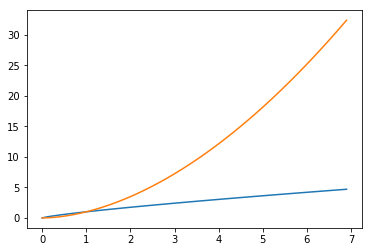

In [86]:
import numpy as np
import matplotlib.pyplot as plt
A=np.arange(0,7,0.1)
plt.plot(A,np.power(A,0.8) )
plt.plot(A,np.power(A,1.8) )

- 게시글은 특성상 대부분의 글이 0~2개의 적은 투표를 받고 극소수의 글이 수 천개의 투표를 받는 양극화 된 분포를 갖음<br>
=> 분자가 linear하게 증가하면 양극화가 심해져 sublinear하게 증가하게 해서 이를 조절<br>
- 분자의 증가 속도 (0.8)< 분모의 증가 속도(1.8) => 좋아요가 많아도 오래 된 글이면 더 빠르게 점수 감소<br>
=> 최신 글일 수록 더 높은 점수<br>
=> 모든 글의 점수는 시간이 지나면 언젠가는 0이 됨<br>
- 그림에서 파랑색은 분자에 대한 함수, 주황색은 분모에 대한 함수로 분모에 대한 함수의 증가 속도가 훨씬 빠름을 알 수 있음

데이터 설명:
- 2015년 10월에서 2016년 9월까지 1년 간 Hacker news 게시글
- 변수<br>
title: 게시글 제목<br>
url: 게시글이 연결된 link<br>
num_points: 좋아요을 받은 수<br>
num_comments: 댓글이 달린 수<br>
author: 게시글 작성자<br>
created_at: 게시글이 작성된 시간<br>
- 출처: https://www.kaggle.com/hacker-news/hacker-news-posts

In [186]:
import os
import pandas as pd
os.chdir('C:/Users/bki19/Desktop/recommender_system')
df=pd.read_csv('./data/HN_posts_year_to_Sep_26_2016_2.csv', low_memory=False)
#df=df.dropna()

In [187]:
df.head(3)

,id,title,url,num_points,num_comments,author,created_at
0,12579008,You have two days to comment if you want stem ...,http://www.regulations.gov/document?D=FDA-2015...,1,0,altstar,9/26/2016 3:26
1,12579005,SQLAR the SQLite Archiver,https://www.sqlite.org/sqlar/doc/trunk/README.md,1,0,blacksqr,9/26/2016 3:24
2,12578997,What if we just printed a flatscreen televisio...,https://medium.com/vanmoof/our-secrets-out-f21...,1,0,pavel_lishin,9/26/2016 3:19


In [188]:
df.shape

(22522, 7)

In [189]:
df['created_at']=pd.to_datetime(df['created_at'])
A=df.iloc[0,6]-df['created_at']
n=len(A)
for i in range(n):
    A[i]=(A[i].total_seconds())/7200

df['time_span']=A

In [190]:
def HN_rank(points,age):
    Score= ((points-1)**0.8)/( (age+2)**1.8 )
    return Score

In [191]:
df['Score']=HN_rank(df['num_points'],df['time_span'])

In [192]:
df2=df.sort_values('Score', ascending=False)

In [193]:
df2.head(10)

,id,title,url,num_points,num_comments,author,created_at,time_span,Score
88,12577787,UnGoogled Chromium: Chromium with enhanced pri...,https://github.com/Eloston/ungoogled-chromium,251,120,kawera,2016-09-25 22:26:00,2.5,5.52802
67,12578028,Appropriate Uses for SQLite,https://sqlite.org/whentouse.html,125,56,ftclausen,2016-09-25 23:27:00,1.99167,3.91435
158,12577005,Finance is Not the Economy,http://www.unz.com/article/finance-is-not-the-...,237,115,the-enemy,2016-09-25 19:40:00,3.88333,3.25842
239,12576124,The decline of Stack Overflow (2015),https://hackernoon.com/the-decline-of-stack-ov...,291,255,abaschin,2016-09-25 16:56:00,5.25,2.63821
127,12577331,Designing and producing 2FA tokens to sell on ...,https://conorpp.com/2016/09/23/designing-and-p...,138,52,conorpp,2016-09-25 20:45:00,3.34167,2.50933
282,12575665,Park.io automating tasks to make $125k per month,https://www.indiehackers.com/businesses/park-io-1,342,146,csallen,2016-09-25 15:14:00,6.1,2.45997
327,12575166,Two years spent spamming spammers back,https://medium.com/@beweinreich/two-years-spam...,406,110,beweinreich,2016-09-25 13:16:00,7.08333,2.2968
37,12578556,"OpenMW, Open Source Elderscrolls III: Morrowin...",https://openmw.org/en/,32,3,rocky1138,2016-09-26 01:24:00,1.01667,2.13767
63,12578100,Adobe and Berkeley's new deep learning image e...,https://github.com/junyanz/iGAN,52,8,visionp,2016-09-25 23:44:00,1.85,2.05223
96,12577685,What I Learned from a Stroke at 26: Make Time ...,http://www.nytimes.com/2016/09/25/jobs/what-i-...,81,28,allsystemsgo,2016-09-25 21:58:00,2.73333,2.02848


- 페널티를 적용 안하고 점수를 계산해 본 결과 
- 2시간이 지날 때 마다 페널티 부여
- '좋아요'를 125개 받은 글이 237개 받은 글이 순위가 더 높음 => 좋아요를 조금 받더라도 최신 글일 수록 훨씬 중요하기 때문

Penalty 적용
- Hacker's news에서 사용하는 penalty는 미리 운영자가 정해 놓은 rule based 방식을 따름
- 이중에 알려진 몇몇 방법은 다음과 같음
-  Url 이 없거나 "Ask HN"이라는 항목의 글은 0.4의 페널티
- Url이 특정 사이트면 0.3의 penalty
- 댓글이 20개 이상이면서 댓글이 좋아요 보다 많으면 $min [1, (\frac{패널티 전 점수}{댓글 수})^{2}]$로 강한 패널티를 줌 => 논란이 되는 글을 추천하지 않기 위해

In [203]:
df3=df
n=df3.shape[0]

for i in range(n):
    if (('Ask HN' in df3['title'][i]) or ( pd.isna(df3['url'][i] )) ):
        df3['Score'][i]=df3['Score'][i]*0.4
    if (df3['num_points'][i]>20 and (df3['num_points'][i] < df3['num_comments'][i]) ):
        df3['Score'][i]=df3['Score'][i]*min(1, (df3['Score'][i]/ df3['num_comments'][i])**2   )

C:\Users\bki19\Anaconda3\envs\tf36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\bki19\Anaconda3\envs\tf36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [206]:
df4=df3.sort_values('Score', ascending=False)

In [207]:
df4.head()

,id,title,url,num_points,num_comments,author,created_at,time_span,Score
88,12577787,UnGoogled Chromium: Chromium with enhanced pri...,https://github.com/Eloston/ungoogled-chromium,251,120,kawera,2016-09-25 22:26:00,2.5,5.52802
67,12578028,Appropriate Uses for SQLite,https://sqlite.org/whentouse.html,125,56,ftclausen,2016-09-25 23:27:00,1.99167,3.91435
158,12577005,Finance is Not the Economy,http://www.unz.com/article/finance-is-not-the-...,237,115,the-enemy,2016-09-25 19:40:00,3.88333,3.25842
239,12576124,The decline of Stack Overflow (2015),https://hackernoon.com/the-decline-of-stack-ov...,291,255,abaschin,2016-09-25 16:56:00,5.25,2.63821
127,12577331,Designing and producing 2FA tokens to sell on ...,https://conorpp.com/2016/09/23/designing-and-p...,138,52,conorpp,2016-09-25 20:45:00,3.34167,2.50933


 - 상위 글에서 penalty를 받은 글이 없어 순위가 변하지는 않음
 - 페널티는 점수를 크게 감소시키기 때문에 원하지 않는 글을 노출 시키지 않는데 효과적
 - Ranking의 질을 높일 수 있지만 검열의 목적으로 악용 될 여지가 있음

# <b>2) Reddit의 추천 방식</b>

- 미국에서 가장 큰 커뮤니티 사이트로 다양한 분야의 정보들이 공유 됨<br>
- Hacker news는 어느 정도 포인트가 쌓여야 싫어요를 누를 수 있지만 Reddit은 바로 가능<br>
- 게시글 추천 알고리즘
$Score=sign(ups-downs-)\times \log_{10}(max(1,|ups-downs|) ) +\frac{age}{45000} $<br>

sign=> 싫어요가 더 많으면 마이너스 점수를 받게 됨<br>
log=> 좋아요와 싫어요의 차이가 클 수록 log 증가하게 됨 (처음 100개의 좋아요가 나중 100개의 좋아요 보다 상승폭이 큼)<br>
age=> 기준점(2005.12.8과의 초 차이) linear하게 증가하기 때문에 앞에 것보다 증가 속도가 빠름


C:\Users\bki19\Anaconda3\envs\tf36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


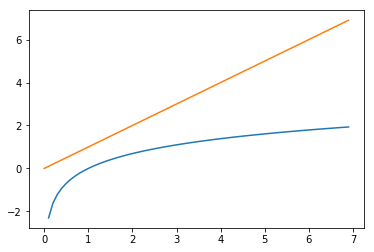

In [208]:
import numpy as np
import matplotlib.pyplot as plt
A=np.arange(0,7,0.1)
plt.plot(A,np.log(A) )
plt.plot(A,A )

- Hacker News와 마찬가지로 최신글에 점수를 더 많이줌
- Hacker News에서는 시간이 지나면 모든 글의 점수는 0으로 수렴
- Reddit은 점수는 변하지 않고 최신 글일 수록 더 높은 점수를 받는 방식

In [209]:
import os
import pandas as pd
os.chdir('C:/Users/bki19/Desktop/recommender_system')
df=pd.read_csv('./data/HN_posts_year_to_Sep_26_2016_2.csv', low_memory=False)

In [210]:
df['created_at']=pd.to_datetime(df['created_at'])
A=df['created_at']-df.iloc[22521,6]
n=len(A)
for i in range(n):
    A[i]=(A[i].total_seconds())

df['time_span']=A

In [223]:
def Reddit_rank(points,age):
    
    Score= points+np.log10(   points   ) + age/45000
    return Score

In [224]:
df['Score']=Reddit_rank(df['num_points'],df['time_span'])

In [225]:
df2=df.sort_values('Score', ascending=False)

In [227]:
df2.head(10)

,id,title,url,num_points,num_comments,author,created_at,time_span,Score
9263,12494998,Pardon Snowden,https://www.pardonsnowden.org/,2553,781,erlend_sh,2016-09-14 08:31:00,1.57338e+06,2591.37
19693,12396331,The Dropbox hack is real,https://www.troyhunt.com/the-dropbox-hack-is-real,1313,539,joshschreuder,2016-08-31 06:13:00,355500,1324.02
21607,12379518,Scammed By A Silicon Valley Startup,https://medium.com/@PennyKim/i-got-scammed-by-...,1311,558,davidkhess,2016-08-29 01:58:00,167400,1317.84
16061,12430298,Philae Found,http://www.esa.int/Our_Activities/Space_Scienc...,1238,125,de_dave,2016-09-05 13:53:00,815100,1259.21
15434,12435236,EU Announces That All Scientific Articles Shou...,http://futurism.com/eu-announces-that-all-euro...,1205,132,emartinelli,2016-09-06 11:41:00,893580,1227.94
8650,12499642,"Announcing new tools, forums, and features",https://github.com/blog/2256-a-whole-new-githu...,1141,163,joshmanders,2016-09-14 18:06:00,1.60788e+06,1179.79
7721,12508356,Elon Musk on How to Build the Future,http://www.ycombinator.com/future/elon/,1104,513,sama,2016-09-15 18:05:00,1.69422e+06,1144.69
3524,12545878,Linux cant be installed on a recent Lenovo laptop,https://www.reddit.com/r/linux/comments/53ri0m...,1052,398,makaronin,2016-09-21 06:31:00,2.17098e+06,1103.27
12511,12463338,How Dropbox Hacks Your Mac,http://applehelpwriter.com/2016/08/29/discover...,1037,412,8bitben,2016-09-09 15:52:00,1.16784e+06,1065.97
18518,12405006,A SpaceX Falcon 9 rocket has exploded at Cape ...,https://techcrunch.com/2016/09/01/a-spacex-fal...,986,534,mariusz79,2016-09-01 13:21:00,467580,999.385


- 상위 글에 HN보다 좋아요를 많이 받은 글이 많아짐
- 시간에 따른 페널티가 HN 알고리즘 보다 약하고 좋아요의 영향력이 훨씬 커짐 (예전 글이 HN보다 많이 노출)
- HN보다 훨씬 단순

# 3. 연결성에 초점을 둔 추천 방식

- 페이지로 연결 된 링크가 많을 수록 많은 방문자들이 유입될 것이다<br>
=> 많이 연결 된 사이트일 수록 사람들이 관심이 많을 것이다<br>
- Goolgle의 Page Rank 알고리즘은 페이지에 연결된 링크의 수에 따라 점수화하는 방법

<b>예제 1</b>

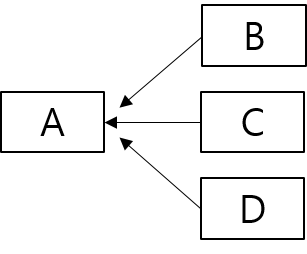

In [12]:
from IPython.display import Image
Image(filename='./pagerank_ex1.png')

- 페이지 A,B,C,D가 존재
- 페이지 B,C,D는 페이지 A로만 연결 돼 있음
- $PR(A)$은 A의 page rank로 B, C, D의 페이지 rank의 점수에 의존함
- $PR(A)^{(0)}=PR(B)^{(0)}=PR(C)^{(0)}=PR(D)^{(0)}=0.25$로 초기의 점수가 동일하다면 다음 단계에서 B,C,D의 방문자는 각각 0.25의 확률로 A로 유입됨
- $PR(A)^{(1)}=PR(B)^{(0)}+PR(C)^{(0)}+PR(D)^{(0)}=0.25+0.25+0.25=0.75$
- 따라서 A로 유입될 확률은 0.75 (자기 자신으로 부터의 유입은 무시)

이 과정이 지속 되면 
- $PR(B)^{(1)}=0$,$PR(C)^{(1)}=0$,$PR(D)^{(1)}=0$
- $PR(A)^{(2)}=0$로 두 번째 단계 부터 모든 Page rank가 0이 됨

<b>예제 2</b>

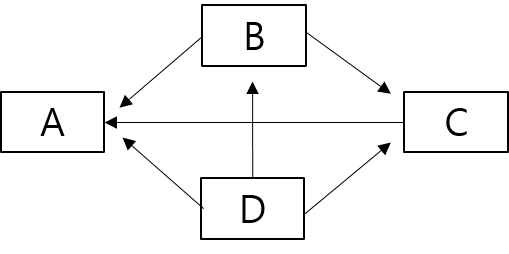

In [13]:
from IPython.display import Image
Image(filename='./pagerank_ex2.png')

- 이제 위와 같이 연결 구조가 더 복잡한 상황에서 보면
- B는 총 2군데, D는 총 세군데와 연결
- $PR(A)^{(1)}=\frac{PR(B)^{(0)} }{2}+PR(C)^{(0)}+ \frac{  PR(D)^{(0)} }{3}=0.25/2+0.25+0.25/3= 0.458$
- B 페이지와 D 페이지 사용자가 A로 갈 확률이 줄어들어 A의 page rank도 감소함
- $PR(B)^{(1)}=\frac{  PR(D)^{(0)} }{3}=0.25/3= 0.083$
- $PR(C)^{(1)}=\frac{PR(B)^{(0)} }{2}+ \frac{  PR(D)^{(0)} }{3}=0.25/2+0.25/3= 0.208$
- $PR(D)^{(1)}=0$

- $PR(A)^{(2)}=0.25$
- $PR(B)^{(2)}=0$
- $PR(C)^{(2)}=0.0416$
- $PR(D)^{(2)}=0$<br>
...<br>
점점 모든 값이 0에 가까워짐

<b>일반화</b>

일반화 하면 다음과 같음<br>
$PR(A)^{(t)}=\sum_{v \in B_{u}}\frac{ PR(v) }{L(v)}^{(t)}$

<b>Damping Factor</b>
- 사용자는 언젠가는 클릭을 멈출 것이기 때문에 $0<d<1$인 damping factor를 도입해서 Page rank가 점차 감소하게 만들음
- $PR(p_{i}^{(t+1)})= \frac{1-d}{N}+ d\sum_{p_{j} \in M(p_{j})}\frac{ PR(p_{j})^{(t)} }{L(p_{j})}$
- damping factor는 솔루션을 unique하게 만드는 기능도 함

<b>Markov Process</b>

- 결국 이 과정은 이 전 시점의 상태가 다음 시점의 상태에 영향을 주는 형태이기 때문에 Markov process라고 할 수 있음<br>
- 사이트간의 유입이 영원히 지속되다가 언젠가는 수렴한다는 가정
- Transition Matrix $M_{(i \times j)}$: 홈페이지 j가 홈페이지 i에 연결 
- $R^{(t+1)}=\begin{bmatrix}
    PR(p_{1})\\
    PR(p_{2})\\
    ...\\
    PR(p_{N})\\
\end{bmatrix}$ $=\begin{bmatrix}
    (1-d)/N \\
    (1-d)/N \\
    ...\\
    (1-d)/N \\
\end{bmatrix}$+$d\begin{bmatrix}
    l(p_{1},p_{1}) & l(p_{1},p_{2}) &...& l(p_{1},p_{N})\\
    l(p_{2},p_{1}) &...&&\\
    ...\\
    l(p_{N},p_{1}) & ...& &l(p_{N},p_{N})\\
\end{bmatrix}R^{(t)}=\frac{1-d}{N} \mathbf{1}+dMR^{(t)}  $

<b>Updating Rule</b>

Initial value: $PR(p_{i})^{(0)}=\frac{1}{N}, i=1...,N  $<br>
$R^{(t+1)}=\frac{1-d}{N} \mathbf{1}+dMR^{(t)}  $<br>
Stoping rule: $|R^{(t+1)}-R^{(t)}|<\epsilon$


<b>예제 3: 구현</b>

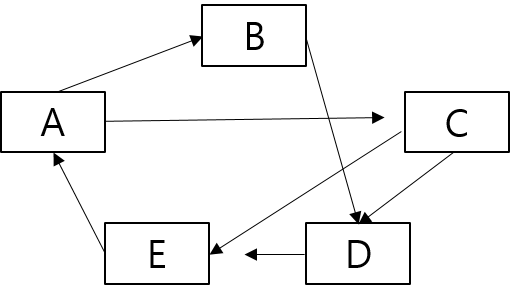

In [40]:
from IPython.display import Image
Image(filename='./pagerank_ex3.png')

In [30]:
M = np.array([[0, 0, 0, 0, 1],
              [0.5, 0, 0, 0, 0],
              [0.5, 0, 0, 0, 0],
              [0, 1, 0.5, 0, 0],
              [0, 0, 0.5, 1, 0]])
N=M.shape[1]
d=0.85
eps=1.0e-8

In [55]:
Rt=np.ones((N, 1), dtype=np.float32)/N
R_stop = np.ones((N, 1), dtype=np.float32) * 100

In [56]:
while np.linalg.norm(Rt - R_stop, 2) > eps:
    R_stop = Rt
    Rt = d * np.matmul(M, Rt) + (1 - d) / N


In [61]:
pd.DataFrame(Rt,columns=['Page Rank'],index=['A','B','C','D','E'])

,Page Rank
A,0.254192
B,0.138032
C,0.138032
D,0.205990
E,0.263755


- B,C로 직접 연결 된 사이트가 하나씩 밖에 없어 낮음 점수를 받음
- D,E로 직접 연결된 사이트가 두개 씩이어서 높은 점수
- A는 직접 하나만 연결 됐지만 E와 연결 돼 있어서 높은 점수를 받은 것으로 보임

<b>4) 실제 데이터에 적용</b>

In [9]:
import os
import pandas as pd
os.chdir('C:/Users/bki19/Desktop/recommender_system')
df = pd.read_csv("./data/hollins.dat",sep=' ')
df=df['6012']
Ind=set(df.index)

In [10]:
df.head()

1                             http://www1.hollins.edu/
2                              http://www.hollins.edu/
3    http://www1.hollins.edu/Docs/CompTech/Network/...
4      http://www1.hollins.edu/Docs/Forms/GetForms.htm
5         http://www1.hollins.edu/Docs/misc/travel.htm
Name: 6012, dtype: object

데이터 소개:<br>
- Hollins 대학교 홈페이지의 웹사이트 간의 연결 여부
- 6012개의 웹사이트가 각각 교내 다른 웹사이트에 연결 되어있는지 표시됨
- 출처: https://github.com/zHaytam/PageRank/tree/master/input

In [11]:
##Outgoing Dataframe
df2=[]
for x in Ind:
    A=df[df.index==x]
    B=list(map(int,A.iloc[1:]))
    df2.append([A.iloc[0],B])
df2=pd.DataFrame(df2)
df2.index=Ind
    

In [12]:
df2.head()

,0,1
1,http://www1.hollins.edu/,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
2,http://www.hollins.edu/,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3..."
3,http://www1.hollins.edu/Docs/CompTech/Network/...,[]
4,http://www1.hollins.edu/Docs/Forms/GetForms.htm,"[7, 19, 21, 85, 86, 87, 88, 89, 90, 91, 92, 93..."
5,http://www1.hollins.edu/Docs/misc/travel.htm,"[7, 19, 21, 85, 88, 89, 90, 91, 93, 154]"


Outgoing link connection
- 해당 사이트가 다른 사이트로 향하는 연결이 있는지
- 1번 사이트는 2,3,4,5, 등의 사이트와 연결
- 2번 사이트는 26,27,.. 등의 사이트와 연결

(array([5.669e+03, 3.120e+02, 1.600e+01, 8.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 3.000e+00]),
 array([  0. ,  18.4,  36.8,  55.2,  73.6,  92. , 110.4, 128.8, 147.2,
        165.6, 184. ]),
 <a list of 10 Patch objects>)

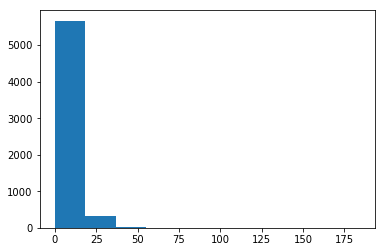

In [15]:
import numpy as np
import matplotlib.pyplot as plt
a=[]
for x in df2[1]:    
        a.append(len(x))
plt.hist(a )

In [17]:
a=0
for x in df2[1]:
    if len(x)>a:
        a=len(x)
print(a)

184


- 다른 사이트로의 연결이 가장 많은 사이트는 184개
- 다른 사이트로의 연결이 없는 사이트가 대부분인 skewed한 분포

In [18]:
##incoming
df4=df.iloc[6012:]
df5=[]
for x in Ind:
    A=df4[df4.values  == str(x) ]
    if np.sum(A)==0:
        df5.append(0)
    else:
        #B=list(map(int,A.iloc[1:]))
        df5.append( list(map(int,A.index ) ) )
df6=pd.DataFrame(df5)
df6.index=Ind
df6.head()

,0
1,0
2,"[1, 8, 16, 18, 20, 23, 26, 27, 28, 29, 30, 31,..."
3,"[1, 351, 374, 377, 528, 1162, 1165, 1168, 1284..."
4,[1]
5,[1]


Incoming connection
- 해당 사이트로 연결하는 사이트의 목록
- 1번 사이트로 연결하는 사이트는 하나도 없음
- 2번 사이트로 연결하는 사이트는 1,8,... 등

In [21]:
#transition matrix

N=len(Ind)
M=np.zeros((N,N))
for i in range(N):
    if df6.iloc[i,0]!=0:
        for j in df6.iloc[i,0]:
            M[i-1,j]+=1
for j in range(N):
    if np.sum(M[:,j])!=0:
        M[:,j]=M[:,j]/np.sum(M[:,j])

In [22]:
def pagerank(M, eps=1.0e-8, d=0.85):
    N=M.shape[1]
    d=0.85
    eps=1.0e-8
    Rt = np.random.rand(N, 1)
    Rt = Rt / np.linalg.norm(Rt, 1)
    R_stop = np.ones((N, 1), dtype=np.float32) * 100
    
    while np.linalg.norm(Rt - R_stop, 2) > eps:
        R_stop = Rt
        Rt = d * np.matmul(M, Rt) + (1 - d) / N
    return Rt

In [23]:
Result=pagerank(M)

In [25]:
HH=df2.loc[:,0]
Result2=pd.DataFrame(Result,index=Ind)
Result2=pd.concat([Result2, HH], axis=1)
Result2.columns=['PageRank','Site']
Result2=Result2.sort_values('PageRank', ascending=False)
Result2.head(10)

,PageRank,Site
1,0.007679,http://www1.hollins.edu/
36,0.002388,http://www.hollins.edu/news-events/news_events...
37,0.002288,http://www.hollins.edu/admissions/visit/visit.htm
51,0.002274,http://www.hollins.edu/academics/library/libto...
60,0.002228,http://www.hollins.edu/academics/library/infor...
5434,0.001808,http://www1.hollins.edu/classes/dance/website/...
27,0.001801,http://www.hollins.edu/admissions/admissions.htm
26,0.001738,http://www.hollins.edu/students/index.htm
42,0.001528,http://www.hollins.edu/community/index.htm
424,0.001448,http://www1.hollins.edu/Docs/academics/Divisio...


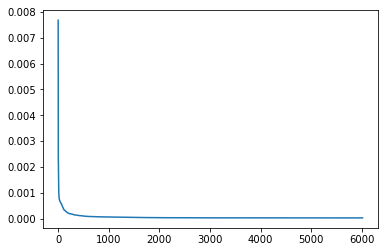

In [32]:
import matplotlib.pyplot as plt
#plt.xscale('log')
plt.plot(np.arange(0,len(Result2.index),1),Result2['PageRank'])

- 다른 사이트로 연결이 가장 많았던 1번 사이트가 가장 높은 rank를 받음
- admission, news, 도서관 관련 사이트가 높은 점수를 받음
- 점수의 편중이 심함<br>
=> 상위 몇 개 사이트 말고는 사이트끼리 연결이 잘 안 되있음

# 4. Simple Recommender의 한계

단순 인기 기반 추천의 문제점
- 개인적인 성향을 고려 못함
- 사람들이 많이 이용한다고 추천할 만한 것은 아님 
- 예를 들어, 해외 여행 중 맛집을 추천해달라고 했는데 맥도날드를 추천
- 유저 그룹에 따라 성향이 다를 수 있음
- 예를 들어 10대와 50대가 좋아하는 성향의 음악은 다름

데이터 및 코드:<br>
- https://github.com/datascienceabe/study_open/tree/master/recommender_system

출처: 
- https://towardsdatascience.com/learning-to-make-recommendations-745d13883951
- https://www.datacamp.com/community/tutorials/recommender-systems-python
- http://www.righto.com/2013/11/how-hacker-news-ranking-really-works.html
- https://medium.com/hacking-and-gonzo/how-reddit-ranking-algorithms-work-ef111e33d0d9
- https://www.math.leidenuniv.nl/scripties/vanRestBach.pdf
- https://github.com/zHaytam/PageRank/tree/master/input
- Page, L., Brin, S., Motwani, R., & Winograd, T. (1999). The PageRank citation ranking: Bringing order to the web. Stanford InfoLab.

데이터 출처:
- https://nbviewer.jupyter.org/github/BadreeshShetty/Learnings-to-make-Recommedations/tree/master/Content%20Filtering/
- https://www.kaggle.com/rounakbanik/the-movies-dataset/data